### Diffusion Limited Aggregation

a)

The positions of particles are stored as 2D vectors, and are updated all at once using the jump function.

The expected behaviour of the particles is random walk, of which the displacement is predicted by the formula:
$$
\Delta S \sim \sqrt{t}
$$
but this is assuming infinite large space without boundary. Thus when I compare the jump operation with the ideal behaviour of random walk, I removed the boudary condition.

The reason why when there is a boudary, the results are higher is probably because that the boundary is periodeic. The particle will jump around the boundary, the dispalcement will hugely increase(~200(size if the grid)). Thus, taking off the boudary is a more presice prediction of the particle behaviour.


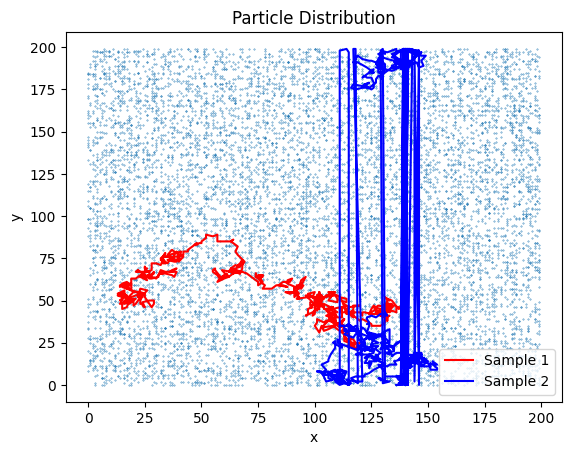

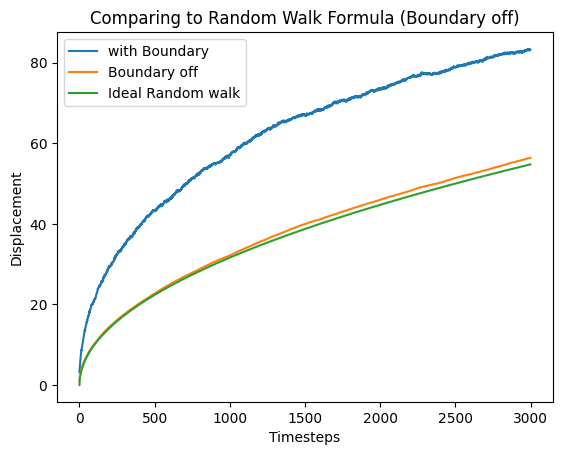

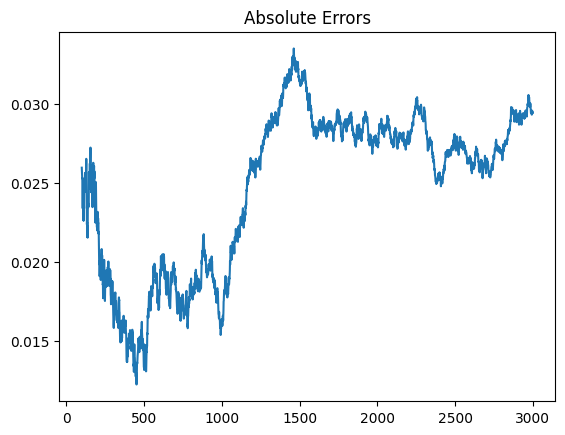

In [8]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt 

# Each step particle jumps to new position (situation: can overlap)
def jump(x, periodic_boundary = True):
    jump_dis = np.random.randint(-1, 2, (len(x), 2))
    if periodic_boundary == True:
        return (x+jump_dis) % 200
    if periodic_boundary == False:
        return (x+jump_dis)

rng = np.random.default_rng()
N = 10000                           # Number of particles
x = np.linspace(0, 199, 200)        # Grid size 
y = np.linspace(0, 199, 200)
gridx , gridy = np.meshgrid(x, y)   # Set the grid
possible_place = np.array([gridx.flatten(), gridy.flatten()]).T

# Pick the particle, so they don't overlap for initial condition
particle_posi_initial =  rng.choice(possible_place, size = N, replace = False)    

# Time step
steps = 3000
i = particle_posi_initial

# Plot trijectary of 2 individual point:
dis_sample = np.linspace(0, steps-1, steps)[::5]
sample_pt1 = []
sample_pt2 = []
for timestep in range(steps):
    i = jump(i)
    if timestep % 5 == 0:     # sample every 5 steps
        sample_pt1.append(i[0])
        sample_pt2.append(i[100])
sample_pt1 = np.array(sample_pt1)
sample_pt2 = np.array(sample_pt2)
plt.plot(sample_pt1[:,0], sample_pt1[:,1], color = "red" , label = "Sample 1")    
plt.plot(sample_pt2[:,0], sample_pt2[:,1], color = "blue", label = "Sample 2")    
plt.scatter(i[:, 0], i[:, 1], s=0.1)
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Particle Distribution")
plt.show()
    

# Compare the results with random walk: (Boundary is taken off) 
i = particle_posi_initial
k = particle_posi_initial.copy()
disoff = []
dis = []
for timestep in range(steps):
    i = jump(i, periodic_boundary=False)
    k = jump(i, periodic_boundary=True)
    hypo = np.hypot(i[:, 0] - particle_posi_initial[:,0], i[:, 1] - particle_posi_initial[:,1])
    hypo1 = np.hypot(k[:, 0] - particle_posi_initial[:,0], k[:, 1] - particle_posi_initial[:,1])
    disoff.append(np.average(hypo))
    dis.append(np.average(hypo1))

t = np.linspace(0, timestep, timestep+1)
plt.plot(t, dis, label = "with Boundary")
plt.plot(t, disoff, label = "Boundary off")
plt.plot(t, np.sqrt(t), label = "Ideal Random walk")
plt.title("Comparing to Random Walk Formula (Boundary off)")
plt.xlabel("Timesteps")
plt.ylabel("Displacement")
plt.legend()
plt.show()

plt.plot(t[100:], abs(disoff-np.sqrt(t))[100:] / np.sqrt(t)[100:])
plt.title("Absolute Errors")
plt.show()

b)

The seed of crystal is planted in the centre of map, size of 6 by 6 square.

Plots show the solid crytal growth. The growth rate is chosen to be depending on **8 surronding positions**. The snapshots are taken at different timesteps, more specifically, t=50, t $\sim$ 120(40% crystalized), and t $\sim$ 250(80% crystalized), respectively.



In [9]:
solid = np.zeros(shape=(200, 200))
solid[97:103, 97:103] = 1            # 6x6 in the centre is the seed solid

fluid = particle_posi_initial        # rest the particle position using same random seed

iccc = 8                             # mode of crystalization

fluid_storage = []
solid_storage = np.array([solid])
for timestep in range(2000):         # Give it a large timestep so every particle can freeze 
    fluid = jump(fluid)
    ind = []
    for i in range(len(fluid)):
        pt = fluid[i]
        if iccc == 4:                # Four grid around the solid
            t = np.sum(solid[int(pt[0]-1):int(pt[0]+2), int(pt[1])])        
            k = np.sum(solid[int(pt[0]), int(pt[1]-1) : int(pt[1]+2)])
        if iccc == 8:                # 8 surronding grid
            t = np.sum(solid[int(pt[0]-1):int(pt[0]+2), int(pt[1]-1) : int(pt[1]+2)])   
            k = 0
                                    # update the solid map if condition serves
        if t+k >= 1:
            solid [int(pt[0]), int(pt[1])] = 1
            ind.append(i)
    fluid = np.delete(fluid, ind, axis=0)
    fluid_storage.append(fluid)
    solid_storage = np.insert(solid_storage,0,  solid, axis=0)

    if len(fluid[:,0]) < 0.2*N:      # Break the loop if 80% particles are frozen
        break


# Because of the way I constructed solid_storage array, it needs to be flip and cut off the first element
solid_storage1 = np.flip(solid_storage[:-1], 0)



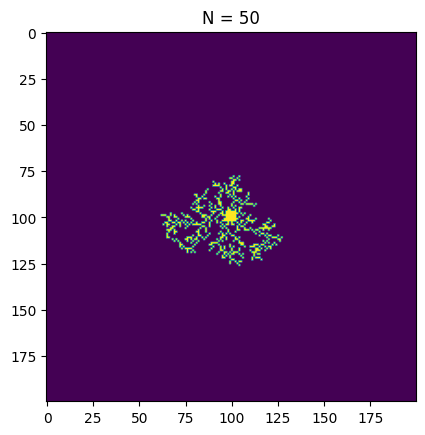

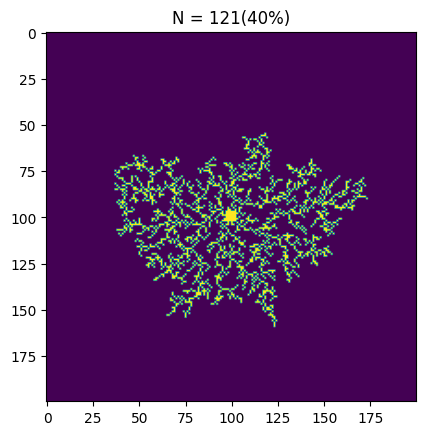

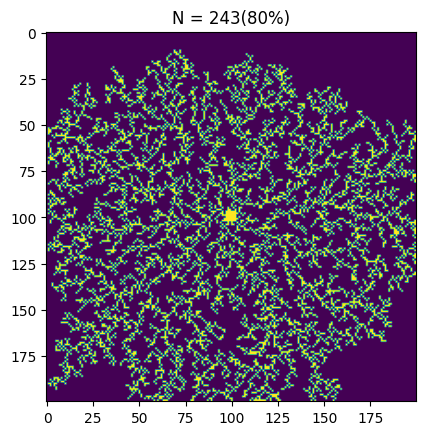

In [10]:
# Plot after initial 50 timestep
plt.imshow(solid_storage1[49])
plt.title("N = 50")
plt.show()

# 40%
plt.imshow(solid_storage1[int(len(solid_storage1) / 2)])
plt.title("N = " + str(int(len(solid_storage1) / 2)) + "(40%)")
plt.show()

# 80%
plt.imshow(solid)
plt.title("N = " + str(len(solid_storage1)) + "(80%)")
plt.show()

c)

The solid growth shows a inverse **s-curve** shape. 

This is reasonable as, at first, the fluid mean displacement is larger($\sim \sqrt{t}$ from part.a) and the seed is smaller, thus the probability for fluid particle to hit the seed is small, hence the speed of growth is low. At later time, the seed size grows exponentially, but the fluid paricle mean displacement is $\sim \sqrt{t}$, thus the growth of crystal enter a "linear" region. Until the fluid is density $\sim 20\%$, the probability of fluid particles hitting crystal is decaying faster than the growth, the line is again start to flattern.

If I would supply the fluid particle, instead of giving it limited amount of particles, the growth of crystal would be just exponential.

Red line shows where is seed crystal is. Green line shows the boundary of lattice, since sqaure lattice, converting to spherical coorinates, leaves the corner less dense.

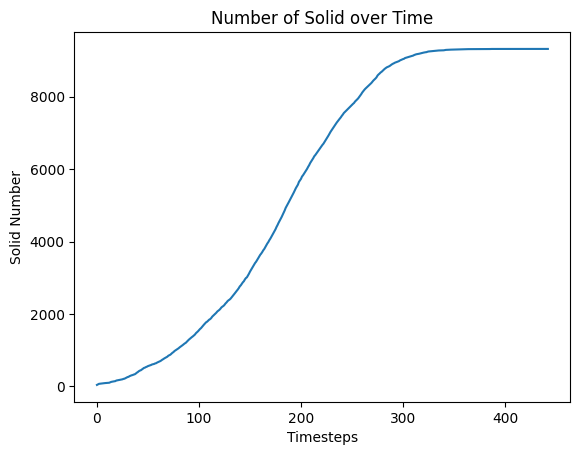

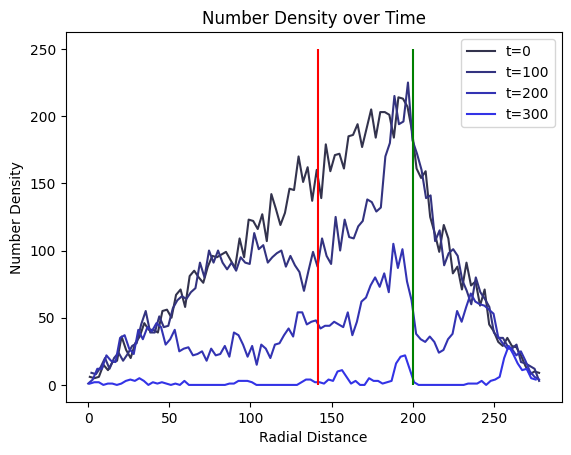

In [11]:
for timestep in range(200):         #  Keep carrying out the crystalization process for another 200 time step
    fluid = jump(fluid)
    ind = []
    for i in range(len(fluid)):
        pt = fluid[i]
        if iccc == 4:                # Four grid around the solid
            t = np.sum(solid[int(pt[0]-1):int(pt[0]+2), int(pt[1])])        
            k = np.sum(solid[int(pt[0]), int(pt[1]-1) : int(pt[1]+2)])
        if iccc == 8:                # 8 surronding grid
            t = np.sum(solid[int(pt[0]-1):int(pt[0]+2), int(pt[1]-1) : int(pt[1]+2)])   
            k = np.sum(solid[int(pt[0]-1):int(pt[0]+2), int(pt[1]-1) : int(pt[1]+2)])
                                    # update the solid map if condition serves
        if t+k >= 1:
            solid [int(pt[0]), int(pt[1])] = 1
            ind.append(i)
    fluid = np.delete(fluid, ind, axis=0)
    fluid_storage.append(fluid)
    solid_storage = np.insert(solid_storage, 0, solid, axis=0)

solid_storage2 = np.flip(solid_storage[:-1], 0)


# Plot the solid numebr vs. time
t = np.arange(len(solid_storage2))
number_of_solid = []
for i in range(len(solid_storage2)):
    number_of_solid.append(np.sum(solid_storage2[i]))
plt.plot(t, number_of_solid)
plt.title("Number of Solid over Time")
plt.xlabel("Timesteps")
plt.ylabel("Solid Number")
plt.show()


# Plot number density of liquid over radial distance
# Convert cartesian coord to radial coord
def convert (x):
    flatx = x.flatten()
    return np.sqrt(flatx[::2]**2 + flatx[1::2]**2)

# Histogram of radial coordinates
def radial_density_hist(storage):             
    rad_storage = []
    for timestep in storage:
        rad_storage.append(np.histogram(convert(timestep), bins=100))
    return np.array(rad_storage, dtype= object)

fluid_radial_density_storage = radial_density_hist(fluid_storage)

# plot for different times
plt.plot(fluid_radial_density_storage[0,1][:-1], fluid_radial_density_storage[0,0], color = (0.2, 0.2, 0.3), label = "t=0")
plt.plot(fluid_radial_density_storage[100,1][:-1], fluid_radial_density_storage[100,0], color = (0.2, 0.2, 0.5), label = "t=100")
plt.plot(fluid_radial_density_storage[200,1][:-1], fluid_radial_density_storage[200,0], color = (0.2, 0.2, 0.7), label = "t=200")
plt.plot(fluid_radial_density_storage[300,1][:-1], fluid_radial_density_storage[300,0], color = (0.2, 0.2, 0.9), label = "t=300")
plt.vlines(x = 200, ymin=0, ymax=250, colors="green")
plt.vlines(x = np.sqrt(2)*100, ymin=0, ymax=250, colors="red")
plt.xlabel("Radial Distance")
plt.ylabel("Number Density")
plt.title("Number Density over Time")
plt.legend()
plt.show()



### Ising Model

a)

The lattice I used is a 50 by 50 grid. The idea behind the algorithm is to pick a random point on the grid, look at the probability ratio to change:
$$
P =\frac{P_{f}}{P_{i}} = \frac{exp(-\frac{E_{f}}{k_{B}T})}{exp(-\frac{E_{i}}{k_{B}T})} = exp(-\frac{E_{f} - E_{i}}{k_{B}T}) = exp(-\frac{\Delta E}{k_{B}T})
$$
Then generate a random number between 0 and 1, make the spin if the probability satisfies:
$$
u_{random} < P
$$
which is the Metropolis-Hastings method.


b)

"Burn-in" phase happens really quickly. Magnetization value quickly stablizes after 150000 timesteps.

At lower temperature, all the spins line-up (depending on the initial condition, if the initialy more positively magnetized, then the result will be line-up to all positive spin, if to start with negatively magnetization, the result will be all negative spin), at higher temperature, the material is demagnetized, the spin distribution become uniform, magnetization becomes 0.

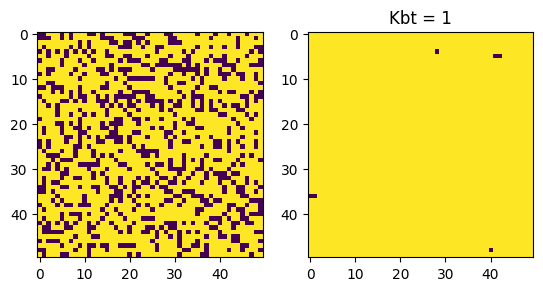

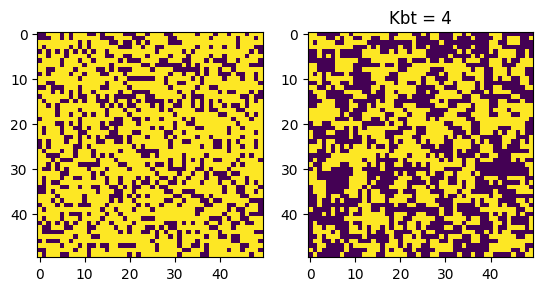

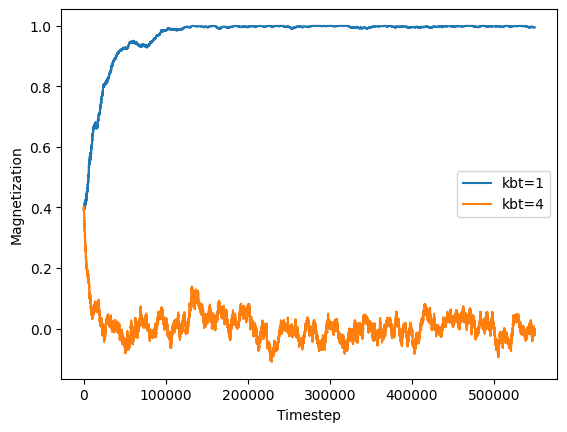

In [12]:
seed = 239
rng = np.random.default_rng(seed)

def energy_pt(pick, model, mode = 1):             
    x, y = pick[0], pick[1]                    
    hori = model[(x-1)%n, y] + model[(x+1)%n, y]   # periodic boundary condition
    vert = model[x, (y-1)%n] + model[x, (y-1)%n]
    if mode == 1:                                  # mode 1: local energy
        return -1 * model[x,y] * (hori+vert)
    if mode == 2:                                  # mode 2: energy difference when flip
        return 2 * model[x,y] * (hori+vert)
    
def energy_grid(model):                                   # I tried previously, to update all the energy in the lattice at once
    left = np.roll(model, 1, axis = 1)                    # But the result behaves differently, although being much much more efficient ~30 seconds
    right = np.roll(model, -1, axis = 1)                  # For original model
    up = np.roll(model, 1, axis = 0)                      # the burn-in phase appears very quick ~50 time steps, and takes ~200 to stablize
    down = np.roll(model, -1, axis = 0)
    return -model*(left+right+up+down)

def magnetization_evolution(startconfig, timestep, kbt):
    config = startconfig.copy()
    config_storage = []
    magne_storage = np.zeros(timestep-1)

    for t in range(timestep-1):                       
        u = rng.uniform()
        coord = rng.choice(range(n), size=2)
        energy_differ = energy_pt(model = config, pick = coord, mode = 2) 

        if u < np.exp(-energy_differ / kbt):
            config[coord[0], coord[1]] = -1 * config[coord[0], coord[1]]          # probability ratio is the energy diference since exp function
            
        config_storage.append(config)
        magne_storage[t] = config.sum()
    
    return config_storage, magne_storage

n = 50
timestepsss = 550000                                     # Since only one position is updated at a time, now I have to do n^2 * 200 ~ 500000
start_config = rng.choice(np.array([-1, 1]), p = np.array([0.3, 0.7]), size=(n, n))   # start with 70% upspin

stor, mag = magnetization_evolution(startconfig = start_config, timestep=timestepsss, kbt=1)
stor111, mag111 = magnetization_evolution(startconfig = start_config, timestep=timestepsss, kbt=4)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(start_config)
ax2.imshow(stor[500000])
plt.title("Kbt = 1")
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(start_config)
ax2.imshow(stor111[500000])
plt.title("Kbt = 4")
plt.show()


plt.plot(range(timestepsss-1), mag/2500, label="kbt=1")
plt.plot(range(timestepsss-1), mag111/2500, label="kbt=4")
plt.xlabel("Timestep")
plt.ylabel("Magnetization")
plt.legend()
plt.show()


c)

The varience of the magnetization is quivalent to heat capacity since:
$$
C_{v} = \frac{dE}{dT}
$$
Because of the large change in energy (equivalent to magnetization, from 1 to 0), the function presents a peak.

This large fluctuation during phase transition is **Schottky anomaly**. And is given by formula:
$$
C_{Schottky} = k_{B}(\frac{\epsilon}{k_{B}T})^2 \frac{exp(\frac{\epsilon}{k_{B}T})}{[exp(\frac{\epsilon}{k_{B}T}) + 1]^2}
$$

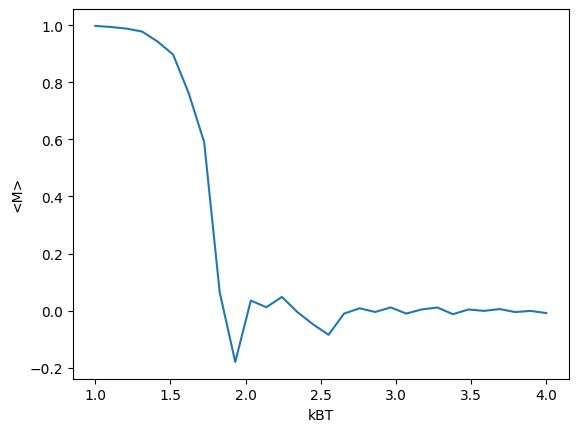

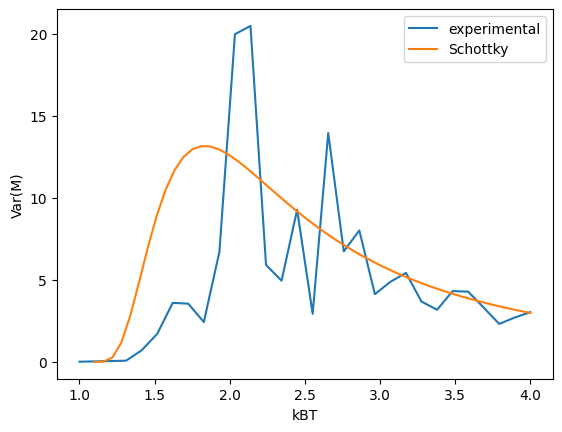

In [13]:
kbt_list = np.linspace(1, 4, 30)
mag_list = []
var_list = []
for kbt in kbt_list:
    storrr, maggg = magnetization_evolution(startconfig = start_config, timestep=timestepsss, kbt=kbt)
    mag_avg = np.mean(maggg[-200000:])
    ma_ver = np.var(maggg[-200000:])
    var_list.append(ma_ver)
    mag_list.append(mag_avg)

def schottky(kbt, energy = 2):
    kbt = kbt -1
    e = np.exp(energy / kbt)
    return (energy/kbt)**2 * e / (np.square(e+1))


plt.plot(kbt_list, np.array(mag_list)/n**2)

plt.xlabel("kBT")
plt.ylabel("<M>")
plt.show()

plt.plot(kbt_list, np.array(var_list)/n**2, label="experimental")
plt.plot(np.linspace(1.1, 4, 50), 30*schottky(np.linspace(1.1, 4, 50)), label="Schottky")
plt.xlabel("kBT")
plt.ylabel("Var(M)")
plt.legend()
plt.show()

### Appendix

Alternative way of updating spins in problem 2. I kept this, just so you can help me to improve accuracy of method (if you want, I know it's not your duty to)

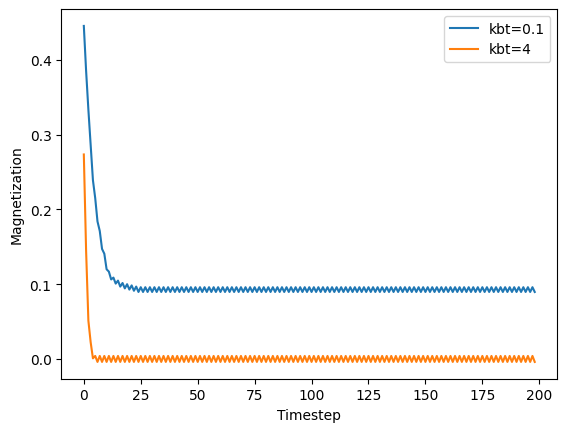

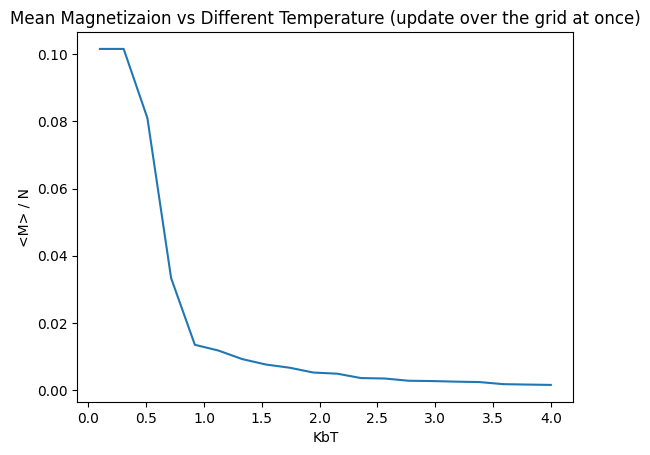

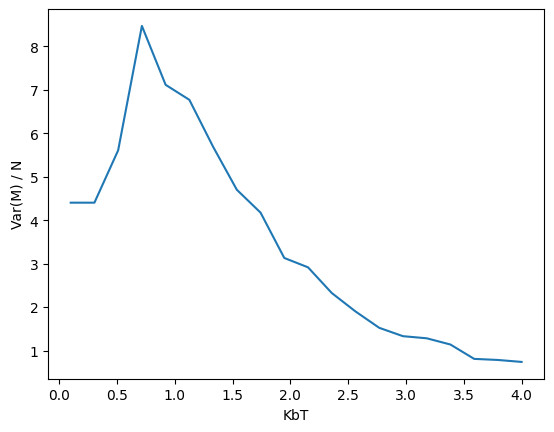

In [14]:
def energy(model, mode = 1):             # Idea behind the method is to move the matrix to adapt the position
    left = np.roll(model, 1, axis=1)     # So that the energy of configuration can be calculate all at once
    right = np.roll(model, -1, axis=1)
    up = np.roll(model, 1, axis=0)
    down = np.roll(model, -1, axis=0)
    subtot = left + right + up + down
    if mode == 1:                        # mode 1: local energy
        return -1 * model * subtot
    if mode == 2:                        # mode 2: energy difference when flip
        return 2 * model * subtot

def magnetization(model):                # Magnetization is just the sum of spins
    return np.sum(model)

def probability(energy_lattice, kbt):
    return np.exp(-1 * energy_lattice / kbt)


# Start with nxn random configuration:
n = 50

# Make the spin start flipping:
def flipping_spins(startconfig, timestep, kbt):
    config = startconfig
    config_storage = np.zeros(shape= (timestep, n, n))
    magne_storage = np.zeros(timestep-1)

    for i in range(timestep-1):
    
        energy_differ =  energy(config, mode = 2)

        u = rng.uniform(size = (n, n))
        
        # update config, only taking the ones are allowed to flip, which determined by comparison of probability
        config = np.where(u <= probability(energy_differ, kbt), -1*config, config)

        # store results
        config_storage[i] = config
        magne_storage[i] = magnetization(config)
    
    return config_storage, magne_storage


# define constant
kbt_list2 = np.linspace(0.1, 4, 20)
timestepsss = 200

plt.plot(range(timestepsss-1), flipping_spins(startconfig=start_config, timestep= timestepsss, kbt=0.1)[1]/(n**2), label="kbt=0.1")
plt.plot(range(timestepsss-1), flipping_spins(startconfig=start_config, timestep= timestepsss, kbt=3)[1]/(n**2), label="kbt=4")
plt.xlabel("Timestep")
plt.ylabel("Magnetization")
plt.legend()
plt.show()

mag_str = []
var_str = []
for t in kbt_list2:
    con, mag = flipping_spins(startconfig= start_config, timestep= timestepsss, kbt= t)
    mag_str.append(np.mean(mag))
    var_str.append(np.var(mag))


plt.plot(kbt_list2, np.array(mag_str)/2500, label="experimental")
plt.xlabel("KbT")
plt.ylabel("<M> / N")
plt.title("Mean Magnetizaion vs Different Temperature (update over the grid at once)")
plt.show()

plt.plot(kbt_list2, np.array(var_str)/2500, label = "experimental")
plt.xlabel("KbT")
plt.ylabel("Var(M) / N")
plt.show()